In [1]:
import pandas as pd

from src.constant import MAIN_DIR
from src.database import DB
from tqdm.auto import tqdm
import numpy as np

PHASE2_DIR = MAIN_DIR / "archive" / "phase2"

In [2]:
records = []
db_path_list = list(PHASE2_DIR.glob("run-policy-*.db"))
progress_bar = tqdm(total=len(db_path_list), desc="Processing")

for db_path in db_path_list:
    parts = db_path.stem.split("-")
    policy, parg, n_train = parts[2:5]
    progress_bar.set_description(f"{policy=}, {parg=}, {n_train=}") 

    db = DB(db_path)
    results = db.get_results()
    results_test = results.loc[results["prefix"].str.startswith("test")]
    # if results_test.shape[0] != 2500:
    if results_test.empty:
        print(f"No results {db_path}")
        continue
    cost = (
        results.loc[results["prefix"].str.startswith("test")]
        .groupby(["instance_id", "prefix"])["cost"]
        .min()  # min for every problem (of 2 solvers)
        .reset_index()
        .groupby("instance_id")["cost"]
        .median()  # median over 5 runs
    )
    if cost.max() >= 100:
        print(f"Test cut-off {db_path}")
    cost = cost.mean()  # total mean score
    cpu_time = (
        results.loc[
            results["prefix"].str.startswith("config")
            & results["cached"].eq(0)
            & results["surrogate"].eq(0),
            "time",
        ].sum()
        / 3600
    )
    surrogate_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].max().mean()
    real_pct = results.loc[results["prefix"].str.startswith("config")].groupby(["solver_id", "instance_id"])["surrogate"].min().eq(0).mean()
    records.append(
        {
            "db_path": db_path.parts[-1],
            "n_train": n_train,
            "policy": policy,
            "parg": parg,
            "cost": cost,
            "cpu_time": cpu_time,
            "surrogate_pct": surrogate_pct,
            "real_pct": real_pct,
        }
    )
    progress_bar.update(1)
progress_bar.close()

df = pd.DataFrame(records)
df

Processing:   0%|          | 0/540 [00:00<?, ?it/s]

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
0,run-policy-baseline--100-1016233.db,100,baseline,,0.10736,14.748363,0.00000,1.000000
1,run-policy-baseline--100-1016239.db,100,baseline,,0.11484,14.685052,0.00000,1.000000
2,run-policy-baseline--100-1016307.db,100,baseline,,0.16572,13.298055,0.00000,1.000000
3,run-policy-baseline--100-1016319.db,100,baseline,,0.18088,11.804989,0.00000,1.000000
4,run-policy-baseline--100-1016325.db,100,baseline,,0.15440,11.919893,0.00000,1.000000
...,...,...,...,...,...,...,...,...
535,run-policy-ib--25-1015015.db,25,ib,,0.24844,0.723468,0.97449,0.219388
536,run-policy-ib--25-1015021.db,25,ib,,0.13472,0.431243,0.97449,0.142857
537,run-policy-ib--25-1015027.db,25,ib,,0.19264,0.541641,0.97449,0.142857
538,run-policy-ib--25-1015033.db,25,ib,,0.20272,0.600577,0.97449,0.142857


In [3]:
df.pivot_table(index=["policy", "parg"], columns="n_train", values="cpu_time", aggfunc="count")

n_train        100  25
policy   parg         
baseline        19  20
ea       25     20  20
         50     19  20
         75     19  20
eb       25     18  20
         50     18  20
         75     18  20
ec       100    18  20
         50     18  20
         75     16  20
ia       1+1    20  20
         1+2    18  20
         2+1    19  20
ib              20  20

In [10]:
IDX = [
    ("baseline", ""),
    ("ea", "25"),
    ("ea", "50"),
    ("ea", "75"),
    ("eb", "75"),
    ("eb", "50"),
    ("eb", "25"),
    ("ec", "100"),
    ("ec", "75"),
    ("ec", "50"),
    ("ia", "1+2"),
    ("ia", "1+1"),
    ("ia", "2+1"),
    ("ib", ""),
]

def agg(x):
    df_agg = x.groupby(["policy", "parg"]).agg(
        cost=("cost", "mean"),
        cpu_time=("cpu_time", "mean"),
        surrogate_pct=("surrogate_pct", "mean"),
        real_pct=("real_pct", "mean"),
    )
    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]
    df_agg["cost_ratio_to_baseline"] = df_agg["cost"] / baseline_cost
    df_agg["cpu_time_ratio_to_baseline"] = df_agg["cpu_time"] / baseline_cpu_time
    df_agg["alpha"] = baseline_cost / df_agg["cost"]
    df_agg["beta"] = (baseline_cpu_time - df_agg["cpu_time"]) * 3600 / df_agg["cost"]
    df_agg["better_than_baseline_until"] = np.floor(df_agg["beta"] / (1 - df_agg["alpha"])) + 1
    df_agg.loc[df_agg["beta"] < 0, "better_than_baseline_until"] = np.nan

    df_agg = df_agg.round(4)
    df_agg = df_agg.loc[IDX, ["cost", "cost_ratio_to_baseline", "cpu_time", "cpu_time_ratio_to_baseline", "surrogate_pct", "real_pct", "alpha", "beta", "better_than_baseline_until"]]
    return df_agg

df25 = df.loc[df["n_train"] == "25"].copy()
df100 = df.loc[df["n_train"] == "100"].copy()

df25_agg = agg(df25)
df100_agg = agg(df100)

In [11]:
df100_agg

cost  cost_ratio_to_baseline  cpu_time  \
policy   parg                                             
baseline       0.1519                  1.0000   13.1297   
ea       25    0.1700                  1.1197    9.9200   
         50    0.1833                  1.2070    6.7729   
         75    0.2067                  1.3611    3.6426   
eb       75    0.2090                  1.3762    6.6310   
         50    0.2234                  1.4711    2.4806   
         25    0.2870                  1.8900    0.8068   
ec       100   0.1572                  1.0351   31.0434   
         75    0.1813                  1.1937   21.1519   
         50    0.1708                  1.1247   16.5583   
ia       1+2   0.1879                  1.2371    8.9573   
         1+1   0.1882                  1.2393    6.7317   
         2+1   0.2202                  1.4499    4.6948   
ib             0.2097                  1.3809    2.1197   

               cpu_time_ratio_to_baseline  surrogate_pct  real_pct   alpha  \
policy   parg                                                                
baseline                           1.0000         0.0000    1.0000  1.0000   
ea       25                        0.7555         0.2440    0.7585  0.8931   
         50                        0.5158         0.4884    0.5165  0.8285   
         75                        0.2774         0.7307    0.2770  0.7347   
eb       75                        0.5050         0.9745    0.7685  0.7266   
         50                        0.1889         0.9745    0.5274  0.6798   
         25                        0.0614         0.9745    0.2864  0.5291   
ec       100                       2.3644         0.9745    1.0000  0.9661   
         75                        1.6110         0.9745    1.0000  0.8377   
         50                        1.2611         0.9745    1.0000  0.8891   
ia       1+2                       0.6822         0.3265    0.6770  0.8084   
         1+1                       0.5127         0.4898    0.5151  0.8069   
         2+1                       0.3576         0.6531    0.3537  0.6897   
ib                                 0.1614         0.9745    0.1727  0.7242   

                      beta  better_than_baseline_until  
policy   parg                                           
baseline            0.0000                         NaN  
ea       25     67951.2848                    635702.0  
         50    124847.5367                    728120.0  
         75    165227.9238                    622832.0  
eb       75    111936.9596                    409464.0  
         50    171594.1103                    535834.0  
         25    154558.9504                    328230.0  
ec       100  -410242.5744                         NaN  
         75   -159305.7294                         NaN  
         50    -72259.9237                         NaN  
ia       1+2    79951.8655                    417198.0  
         1+1   122376.3226                    633739.0  
         2+1   137907.7188                    444465.0  
ib             189002.3517                    685241.0

In [12]:
df100_agg.to_excel("tmp.xlsx")

In [20]:
df.loc[(df["policy"] == "ec") & (df["parg"] == "50") & (df["n_train"] == "100")].sort_values(by="cost")

,db_path,n_train,policy,parg,cost,cpu_time,surrogate_pct,real_pct
324,run-policy-ec-50-100-1016784.db,100,ec,50,0.11336,16.559521,0.97449,1.0
322,run-policy-ec-50-100-1016768.db,100,ec,50,0.11752,16.693723,0.97449,1.0
312,run-policy-ec-50-100-1016469.db,100,ec,50,0.12408,16.458814,0.97449,1.0
319,run-policy-ec-50-100-1016744.db,100,ec,50,0.13232,18.385807,0.97449,1.0
313,run-policy-ec-50-100-1016485.db,100,ec,50,0.14124,17.620577,0.97449,1.0
315,run-policy-ec-50-100-1016501.db,100,ec,50,0.15028,18.348431,0.97449,1.0
317,run-policy-ec-50-100-1016517.db,100,ec,50,0.15488,16.441139,0.97449,1.0
325,run-policy-ec-50-100-1016792.db,100,ec,50,0.15776,17.681901,0.97449,1.0
309,run-policy-ec-50-100-1016445.db,100,ec,50,0.15964,19.812370,0.97449,1.0
327,run-policy-ec-50-100-1016808.db,100,ec,50,0.17500,15.988941,0.97449,1.0


In [14]:
# db = DB(PHASE2_DIR / "run-policy-ib--100-1016238.db")

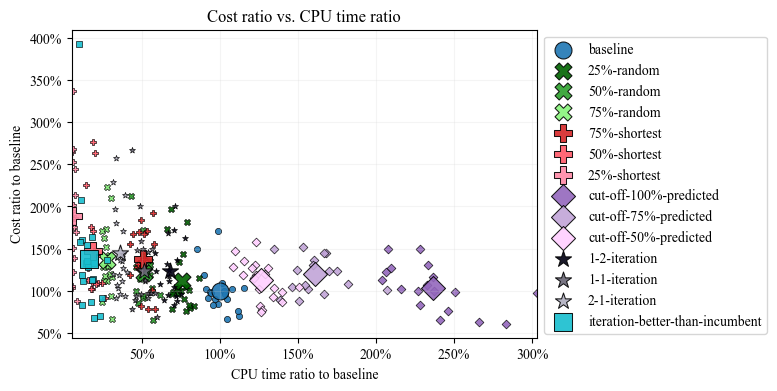

In [15]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.2
plt.rcParams["grid.color"] = "#cccccc"
plt.rcParams["axes.xmargin"] = 0

COLORS = {
    ("baseline", ""): "#1f77b4",
    ("ea", "25"): "#006300",
    ("ea", "50"): "#2ca02c",
    ("ea", "75"): "#89f57b",
    ("eb", "75"): "#d62728",
    ("eb", "50"): "#ff5968",
    ("eb", "25"): "#ff8aa7",
    ("ec", "100"): "#9467bd",
    ("ec", "75"): "#c1a4d8",
    ("ec", "50"): "#ffcfff",
    ("ia", "1+2"): "#010013", 
    ("ia", "1+1"): "#696676",
    ("ia", "2+1"): "#b1afc0",
    ("ib", ""): "#17becf",
}

LABELS = {
    ("baseline", ""): "baseline",
    ("ea", "25"): "25%-random",
    ("ea", "50"): "50%-random",
    ("ea", "75"): "75%-random",
    ("eb", "75"): "75%-shortest",
    ("eb", "50"): "50%-shortest",
    ("eb", "25"): "25%-shortest",
    ("ec", "100"): "cut-off-100%-predicted",
    ("ec", "75"): "cut-off-75%-predicted",
    ("ec", "50"): "cut-off-50%-predicted",
    ("ia", "1+2"): "1-2-iteration", 
    ("ia", "1+1"): "1-1-iteration",
    ("ia", "2+1"): "2-1-iteration",
    ("ib", ""): "iteration-better-than-incumbent",
}

MARKERS = {
    "baseline": "o",
    "ea": "X",
    "eb": "P",
    "ec": "D",
    "ia": "*",
    "ib": "s",
}

def plot_cost_vs_cpu_time_ratio(df, df_agg, plot_all=False):
    fig, ax = plt.subplots(figsize=(6, 4))

    baseline_cost = df_agg.at[("baseline", ""), "cost"]
    baseline_cpu_time = df_agg.at[("baseline", ""), "cpu_time"]

    for (policy, parg), row in df_agg.iterrows():
        if plot_all:
            _ = df.loc[(df["policy"] == policy) & (df["parg"] == parg)]
            plt.scatter(
                _["cpu_time"] / baseline_cpu_time,
                _["cost"] / baseline_cost,
                s=20,
                alpha=0.9,
                color=COLORS[(policy, parg)],
                marker=MARKERS[policy],
                linewidths=0.5,
                edgecolor="black",
            )
        plt.scatter(
            row["cpu_time_ratio_to_baseline"],
            row["cost_ratio_to_baseline"],
            s=150,
            alpha=0.9,
            color=COLORS[(policy, parg)],
            marker=MARKERS[policy],
            linewidths=0.75,
            edgecolor="black",
            label=LABELS[(policy, parg)],
        )

    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("CPU time ratio to baseline")
    plt.ylabel("Cost ratio to baseline")
    if not plot_all:
        plt.xlim(0, 2.5)
        plt.ylim(0.9, 1.66)
    plt.title("Cost ratio vs. CPU time ratio")
    return fig, ax

# fig, ax = plot_cost_vs_cpu_time_ratio(df25, df25_agg, plot_all=True)
fig, ax = plot_cost_vs_cpu_time_ratio(df100, df100_agg, plot_all=True)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()

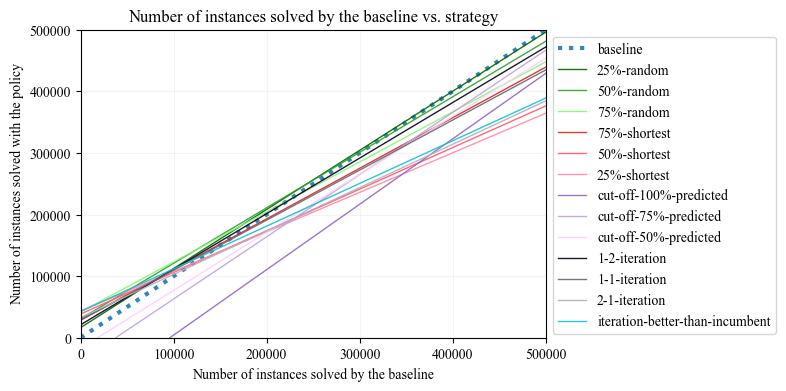

In [11]:
def plot_lines(df_agg, lim):
    fig, ax = plt.subplots(figsize=(6, 4))

    for (policy, parg), row in df_agg.iterrows():
        cost = row["cost"]
        cpu_time = row["cpu_time"]
        ax.axline(
            (0, row["beta"]),
            slope=row["alpha"],
            alpha=0.9,
            color=COLORS[(policy, parg)],
            lw=1 if policy != "baseline" else 3,
            ls="-" if policy != "baseline" else "dotted",
            label=LABELS[(policy, parg)],
        )

    plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
    plt.xlabel("Number of instances solved by the baseline")
    plt.ylabel("Number of instances solved with the policy")
    plt.xlim(0, lim)
    plt.ylim(0, lim)
    plt.title("Number of instances solved by the baseline vs. strategy")
    return fig, ax

fig, ax = plot_lines(df25_agg, 500000)
# fig, ax = plot_lines(df100_agg, 1000000)
# plt.savefig("fig.png", dpi=300, bbox_inches="tight")
plt.show()